## Resources
- https://www.youtube.com/watch?v=ex2qllcVneY
- https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html
- https://colab.research.google.com/drive/1LJir3T6M6Omc2Vn2GV2cDW_GV2YfI53_?usp=sharing

In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 11.5 MB/s 
     |████████████████████████████████| 3.5 MB 11.9 MB/s 
     |████████████████████████████████| 145 kB 12.7 MB/s 
     |████████████████████████████████| 74 kB 2.3 MB/s 
     |████████████████████████████████| 112 kB 36.9 MB/s 
     |████████████████████████████████| 596 kB 35.1 MB/s 


In [2]:
import torch
torch.__version__

'1.10.0+cu111'

## Set Device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Helper function for visualization.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

## Loading Cora dataset

In [5]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


### Node features

In [6]:
print(data.x.shape) # [No. Nodes x Features]

torch.Size([2708, 1433])


### About Edge index

In [7]:
data.edge_index.t() 
# A - B
# A - C
# ....
# ....
# D - E
# where A,B,C and E are nodes/vertices of graph

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

### About labels

In [8]:
data.y.shape

torch.Size([2708])

In [9]:
data.y[0:10]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])

# GCN for node classification

In [10]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv #GATConv

In [11]:
NUM_CLASSES = dataset.num_classes
NUM_FEATURES = dataset.num_features

In [12]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels=16):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(NUM_FEATURES, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, NUM_CLASSES)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer 
        x = F.softmax(self.out(x), dim=1)
        return x

In [13]:
model = GCN(hidden_channels=16).to(device)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


### Set optimizer and cirterion

In [14]:
# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=decay)

# Intialize criterion

criterion = torch.nn.CrossEntropyLoss()

### Send data to device

In [15]:
data = data.to(device)


## Train Loop

In [16]:
from tqdm.notebook import tqdm # progress bar

In [17]:
NUM_EPOCHS = 500
loop = tqdm(range(NUM_EPOCHS), total=NUM_EPOCHS, leave=True)
    
for epoch in loop:
    ## model train
    model.train()
    optimizer.zero_grad()

    y_pred = model(data.x, data.edge_index)
    loss = criterion(y_pred[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    ## progress bar
    loop.set_description(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]")
    loop.set_postfix(train_loss=loss.item())

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
### Let's visualize the embeddings after training

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


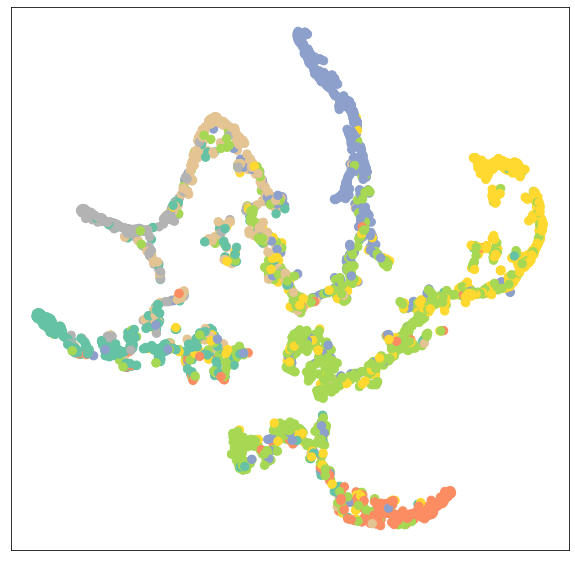

In [18]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y.cpu().numpy())

# Testing the model

In [20]:
model.eval()

y_pred = model(data.x, data.edge_index)
y_pred_max = y_pred.argmax(dim=1)
correct = (y_pred_max[data.test_mask] == data.y[data.test_mask]).sum()
test_acc = int(correct) / data.test_mask.sum()
test_acc.item()

0.6760000586509705